In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Cell 2: Load each market's predictions CSV
import pandas as pd

files = {
     'India':   '/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/predictions/cnn_lstm_predictions_india.csv',
    'Ireland': '/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/predictions/cnn_lstm_predictions_ireland.csv',
    'USA':     '/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/predictions/cnn_lstm_predictions_usa.csv'
}

preds = {}
for market, path in files.items():
    df = pd.read_csv(path, parse_dates=["Date"])
    # Expecting columns: ['Date','Actual_Close','Predicted_Close']
    if not {"Actual_Close","Predicted_Close"}.issubset(df.columns):
        raise KeyError(f"{market} CSV missing Actual_Close or Predicted_Close")
    preds[market] = df.set_index("Date")
    print(f"Loaded {market}: {df.shape[0]} rows, columns = {df.columns.tolist()}")

Loaded India: 284 rows, columns = ['Date', 'Actual_Close', 'Predicted_Close', 'Market']
Loaded Ireland: 284 rows, columns = ['Date', 'Actual_Close', 'Predicted_Close', 'Market']
Loaded USA: 284 rows, columns = ['Date', 'Actual_Close', 'Predicted_Close', 'Market']


In [23]:
# Cell 3: Define the tunable model builder
def build_cnn_lstm_model(hp):
    # pull input_shape from a global or closure
    input_shape = hp.Fixed("input_shape", global_input_shape)

    model = Sequential()
    # Conv1D hyperparameters
    filters     = hp.Int("filters",     32, 128, step=32)
    kernel_size = hp.Choice("kernel_size", [3,5])
    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation="relu",
                     input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM + Dropout
    lstm_units = hp.Int("lstm_units", 32, 128, step=32)
    model.add(LSTM(units=lstm_units, activation="tanh"))
    dropout_rate = hp.Float("dropout", 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Output
    model.add(Dense(1))

    # Compile with tunable learning rate
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [24]:
# Cell 4: Compute RMSE & MAE from these loaded predictions
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

results = {}
for market, df in preds.items():
    y_true = df["Actual_Close"].values
    y_pred = df["Predicted_Close"].values

    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    results[market] = {"rmse": rmse, "mae": mae}
    print(f"{market} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")

India → RMSE: 471.12, MAE: 390.21
Ireland → RMSE: 247.55, MAE: 189.38
USA → RMSE: 146.15, MAE: 107.48


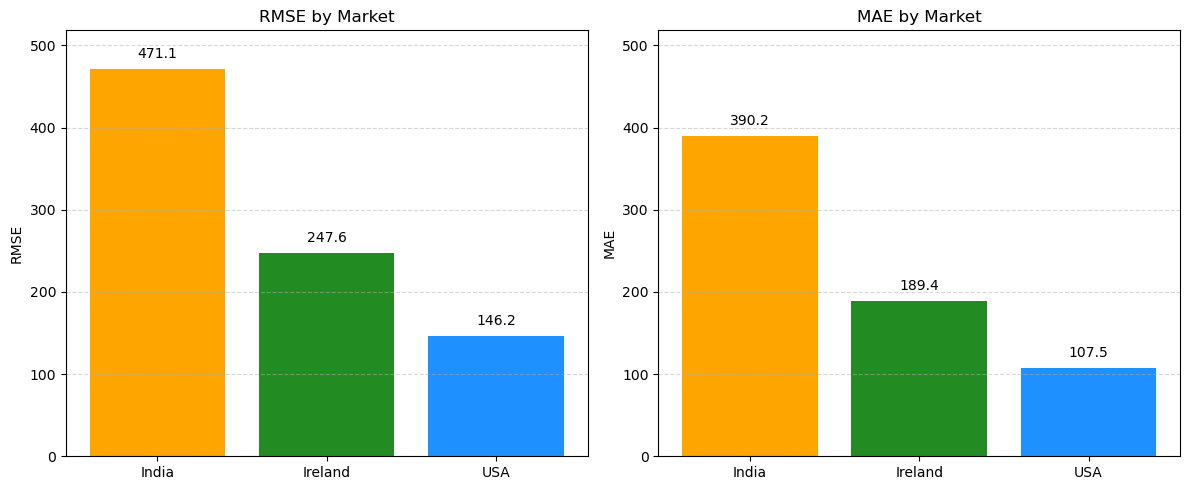

In [26]:
# turn your results into a DataFrame
df_res = pd.DataFrame(results).T.reset_index().rename(columns={'index':'Market'})

# set up the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

metrics = ['rmse','mae']
titles  = ['RMSE by Market','MAE by Market']
colors  = ['#ffa500','#228b22','#1e90ff']  # India/IE/US

for ax, metric, title in zip(axes, metrics, titles):
    ax.bar(df_res['Market'], df_res[metric], color=colors)
    ax.set_title(title)
    ax.set_ylabel(metric.upper())
    ax.set_xlabel('')
    ax.set_ylim(0, df_res[metrics].max().max() * 1.1)  # same y-limit for both

    # annotate bars
    for idx, val in enumerate(df_res[metric]):
        ax.text(idx, 
                val + df_res[metrics].max().max()*0.02, 
                f"{val:.1f}", 
                ha='center', 
                va='bottom')

    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 4ms/step


India:  RMSE=573.25, MAE=473.07


5/5 [==============================] - 0s 3ms/step


Ireland:  RMSE=450.57, MAE=367.94


5/5 [==============================] - 0s 3ms/step
USA:  RMSE=206.80, MAE=172.71
               RMSE         MAE  filters  kernel_size  lstm_units  dropout  \
Market                                                                       
India    573.251361  473.066365       96            3         128      0.2   
Ireland  450.566212  367.944164       64            5          96      0.1   
USA      206.799636  172.708984       96            5         128      0.4   

         learning_rate  
Market                  
India         0.003613  
Ireland       0.001120  
USA           0.001550  


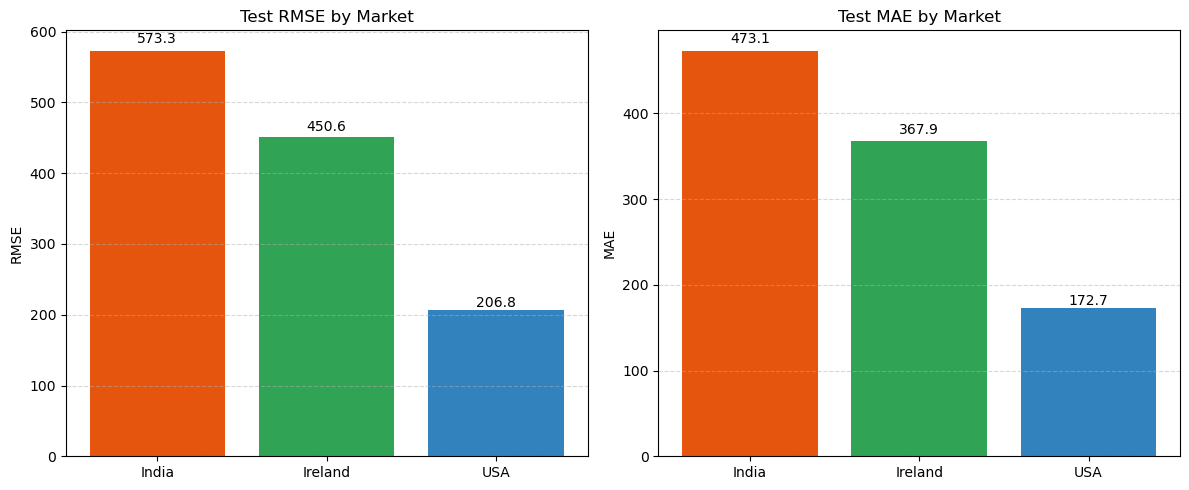

In [30]:
# Cell 1: Imports & Seed
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras_tuner as kt
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

# Cell 2: Settings
DATA_FILES = {
    "India":   "/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/cleaned/Cleaned_INDIA.csv",
    "Ireland": "/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/cleaned/Cleaned_IRELAND.csv",
    "USA":     "/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/cleaned/Cleaned_USA.csv"
}
WINDOW_SIZE = 60

FEATURE_COLS = [
    "Open","High","Low","Close","Volume",
    "LogRet","MA_5","MA_20","Vol_10","RSI_14","MACD","Signal"
]
TARGET_COL = "Target"

# Cell 3: Sequence creation + scaling helper
def load_and_preprocess(path):
    # 1) Load
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date")
    # 2) Scale features & target separately
    feat_scaler = MinMaxScaler()
    tgt_scaler  = MinMaxScaler()
    X_raw = feat_scaler.fit_transform(df[FEATURE_COLS])
    y_raw = tgt_scaler .fit_transform(df[[TARGET_COL]])
    # 3) Create windows
    Xs, ys = [], []
    for i in range(len(df) - WINDOW_SIZE):
        Xs.append(X_raw[i:i+WINDOW_SIZE])
        ys.append(y_raw[i+WINDOW_SIZE])
    X = np.array(Xs)    # shape (samples, WINDOW_SIZE, features)
    y = np.array(ys).squeeze()  # shape (samples,)
    # 4) Time-based 3-way split
    n = len(X)
    i1 = int(0.75 * n)
    i2 = int(0.90 * n)
    X_train, X_val, X_test = X[:i1],  X[i1:i2],   X[i2:]
    y_train, y_val, y_test = y[:i1],  y[i1:i2],   y[i2:]
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), feat_scaler, tgt_scaler

# Cell 4: Hypermodel builder
def build_model(hp):
    model = Sequential()
    # Conv1D
    f = hp.Int("filters", 32, 128, step=32)
    k = hp.Choice("kernel_size", [3,5])
    model.add(Conv1D(f, k, activation="relu", input_shape=global_input_shape))
    model.add(MaxPooling1D(2))
    # LSTM + Dropout
    u = hp.Int("lstm_units", 32, 128, step=32)
    d = hp.Float("dropout", 0.1, 0.5, step=0.1)
    model.add(LSTM(u, activation="tanh"))
    model.add(Dropout(d))
    # Output
    model.add(Dense(1))
    # Compile
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      loss="mse", metrics=["mae"]
    )
    return model

# Cell 5: Loop through markets, tune & evaluate
results = []
for market, path in DATA_FILES.items():
    # Preprocess
    (X_train, y_train), (X_val, y_val), (X_test, y_test), _, tgt_scaler = \
        load_and_preprocess(path)
    global_input_shape = X_train.shape[1:]  # e.g. (60,12)
    # Tuner
    tuner = kt.RandomSearch(
        build_model,
        objective="val_loss",
        max_trials=20,
        directory="kt_dir",
        project_name=market
    )
    stop = EarlyStopping("val_loss", patience=5, restore_best_weights=True)
    tuner.search(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=50,
      callbacks=[stop],
      verbose=0
    )
    # Best model & test eval
    best_hp    = tuner.get_best_hyperparameters(1)[0]
    best_model = tuner.hypermodel.build(best_hp)
    best_model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=50,
      callbacks=[stop],
      verbose=0
    )
    # Predict & inverse‐scale
    y_pred_scaled = best_model.predict(X_test)
    y_true_scaled = y_test.reshape(-1,1)
    y_pred = tgt_scaler.inverse_transform(y_pred_scaled)
    y_true = tgt_scaler.inverse_transform(y_true_scaled)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    # Record
    results.append({
        "Market": market,
        "RMSE":     float(rmse),
        "MAE":      float(mae),
        **{k: best_hp.get(k) for k in ["filters","kernel_size","lstm_units","dropout","learning_rate"]}
    })
    print(f"{market}:  RMSE={rmse:.2f}, MAE={mae:.2f}")

# Cell 6: Results table
df_res = pd.DataFrame(results).set_index("Market")
df_res.to_csv("multi_market_tuning_results.csv")
print(df_res)

# Cell 7: Bar chart compare
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=False)
colors = ["#e6550d","#31a354","#3182bd"]
for ax, metric, title in zip(
    axes, ["RMSE","MAE"], ["Test RMSE by Market","Test MAE by Market"]
):
    ax.bar(df_res.index, df_res[metric], color=colors)
    ax.set_title(title); ax.set_ylabel(metric)
    for i, v in enumerate(df_res[metric]):
        ax.text(i, v*1.02, f"{v:.1f}", ha="center")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

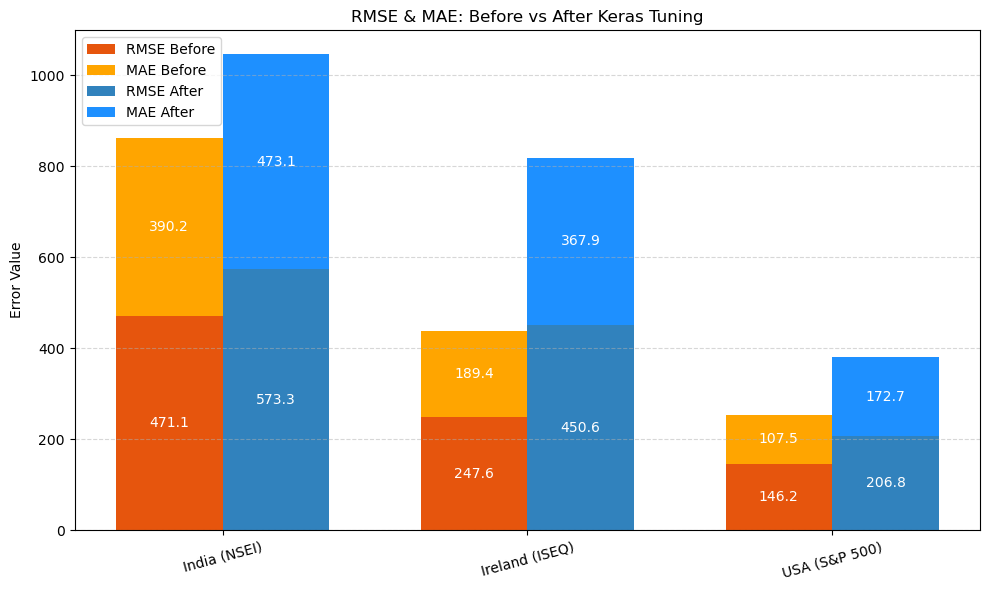

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Replace these with your actual numbers:
markets       = ["India (NSEI)", "Ireland (ISEQ)", "USA (S&P 500)"]
rmse_before   = [471.12,      247.55,        146.15]   # baseline RMSE
mae_before    = [390.21,      189.38,        107.48]   # baseline MAE
rmse_after    = [573.28,      450.64,        206.83]   # tuned RMSE
mae_after     = [473.09,      367.91,        172.68]   # tuned MAE

# 2. Set up the x locations and width
x = np.arange(len(markets))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(10,6))

# 3. Plot before & after bars
bars1 = ax.bar(x - width/2, rmse_before, width, label='RMSE Before', color='#e6550d')
bars2 = ax.bar(x - width/2, mae_before,  width, label='MAE Before',  color='#ffa500', bottom=rmse_before)
#  stacked-for demonstration. If you prefer side-by-side RMSE/MAE before, plot separately.

bars3 = ax.bar(x + width/2, rmse_after,  width, label='RMSE After',  color='#3182bd')
bars4 = ax.bar(x + width/2, mae_after,   width, label='MAE After',   color='#1e90ff', bottom=rmse_after)
#  stacked-for demonstration. If you prefer side-by-side RMSE/MAE after, plot separately.

# 4. Annotate each bar
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2),
                    ha='center', va='center', fontsize=10, color='white')

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)
annotate_bars(bars4)

# 5. Formatting
ax.set_ylabel('Error Value')
ax.set_title('RMSE & MAE: Before vs After Keras Tuning')
ax.set_xticks(x)
ax.set_xticklabels(markets, rotation=15)
ax.legend(loc='upper left')

ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
